In [1]:
# Import essential libraries
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean,rolling_max,rolling_min

from xgboost import plot_importance, plot_tree

from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

import xgboost as xgb  # xgb stuff
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

/var/folders/c3/z8gl7_754n15kcrx5rz7k0840000gn/T/ipykernel_12972/3743164934.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Access to Local Files

In [3]:
# access files
path = 'dataset/'
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
order_payment = pd.read_csv(path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
order_dataset = pd.read_csv(path + 'olist_orders_dataset.csv')
products = pd.read_csv(path + 'olist_products_dataset.csv')
sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')
product_category = pd.read_csv(path + 'product_category_name_translation.csv')


# Data Exploration

In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [6]:
order_payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [7]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [9]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [10]:
product_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [11]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [12]:
order_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [13]:
def missing_col(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values.sort_values(ascending = False)

    return missing_values

def df_info_(df):
    """
        Information about the DataFrame
    """

    features_dtypes = df.dtypes
    rows,columns = df.shape

    missing_cols = missing_col(df)
    features_names = missing_cols.index.values
    missing_values = missing_cols.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                        'Number of Missing Values'.upper(),
                                        'The first few samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_cols),3))+' %'), end=" ")

        for i in range(5):
            print(df[features_names].iloc[i], end=",")

        print("="*50)

In [14]:
df_info_(customers)

===> This data frame contains 99441 rows and 5 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
customer_id     object         0-nan %              06b8999e2fba1a1fbc88172c00ba8bc7,18955e83d337fd6b2def6b18a428ac77,4e7b3e00288586ebd08712fdd0374a03,b2b6027bc5c5109e529d4dc6358b12c3,4f2d8ab171c80ec8364f7c12e35b23ad,==================================================
customer_unique_id object         0-nan %              861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c,345ecd01c38d18a9036ed96c73b8d066,==================================================
customer_zip_code_prefix int64          0-nan %              14409,9790,1151,8775,13056,==================================================
customer_city   object         0-nan %              franca,sao bernardo do campo,sao paulo,mogi das cruzes,campinas,==================================================
customer_state  object

In [15]:
df_info_(products)

===> This data frame contains 32951 rows and 9 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
product_category_name object         610-24.918 %         perfumaria,artes,esporte_lazer,bebes,utilidades_domesticas,==================================================
product_name_lenght float64        610-24.918 %         40.0,44.0,46.0,27.0,37.0,==================================================
product_description_lenght float64        610-24.918 %         287.0,276.0,250.0,261.0,402.0,==================================================
product_photos_qty float64        610-24.918 %         1.0,1.0,1.0,1.0,4.0,==================================================
product_weight_g float64        2-0.082 %            225.0,1000.0,154.0,371.0,625.0,==================================================
product_length_cm float64        2-0.082 %            16.0,30.0,18.0,26.0,20.0,==================================================
product_height_cm float64       

In [16]:
df_info_(sellers)

===> This data frame contains 3095 rows and 4 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
seller_id       object         0-nan %              3442f8959a84dea7ee197c632cb2df15,d1b65fc7debc3361ea86b5f14c68d2e2,ce3ad9de960102d0677a81f5d0bb7b2d,c0f3eea2e14555b6faeea3dd58c1b1c3,51a04a8a6bdcb23deccc82b0b80742cf,==================================================
seller_zip_code_prefix int64          0-nan %              13023,13844,20031,4195,12914,==================================================
seller_city     object         0-nan %              campinas,mogi guacu,rio de janeiro,sao paulo,braganca paulista,==================================================
seller_state    object         0-nan %              SP,SP,RJ,SP,SP,==================================================


In [17]:
df_info_(order_dataset)

===> This data frame contains 99441 rows and 8 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
order_delivered_customer_date object         2965-60.412 %        2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,==================================================
order_delivered_carrier_date object         1783-36.328 %        2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,==================================================
order_approved_at object         160-3.26 %           2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23,2017-11-18 19:45:59,2018-02-13 22:20:29,==================================================
order_id        object         0-0.0 %              e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,============

# Data Processing

In [61]:
# Data Merge by relationship chart
orders = order_dataset.merge(order_items, on = 'order_id', how = 'left')  # 1 to many relationship because 1 order might have multiple items.
orders = orders.merge(order_payment, how = 'inner', on = 'order_id')
orders = orders.merge(order_reviews, how = 'inner', on = 'order_id')
orders = orders.merge(products, how = 'inner', on = 'product_id')
orders = orders.merge(sellers, how = 'inner', on = 'seller_id')

print(orders.shape)

(117329, 35)


In [80]:
orders.head(30)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
6,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,1.0,b00a32a0b42fd65efb58a5822009f629,...,58.0,398.0,3.0,238.0,20.0,10.0,15.0,9350,maua,SP
7,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,2017-08-15 02:15:13,2017-08-16 15:52:29,2017-08-25 21:59:26,2017-08-28 00:00:00,1.0,b00a32a0b42fd65efb58a5822009f629,...,58.0,398.0,3.0,238.0,20.0,10.0,15.0,9350,maua,SP
8,4f2acff0b7d2bcc4a408abe5a223d407,d67b6cca5a87299f711a6961f579fe67,delivered,2017-08-01 16:31:35,2017-08-02 02:50:25,2017-08-03 14:36:34,2017-08-09 19:56:50,2017-08-23 00:00:00,1.0,b00a32a0b42fd65efb58a5822009f629,...,58.0,398.0,3.0,238.0,20.0,10.0,15.0,9350,maua,SP
9,019aaee09698daf81dcffe9d94a18b5c,e3893e579755de4feb1a4d0313c103fa,delivered,2017-08-10 14:04:58,2017-08-10 14:23:38,2017-08-11 13:52:35,2017-08-12 11:56:49,2017-08-23 00:00:00,1.0,b00a32a0b42fd65efb58a5822009f629,...,58.0,398.0,3.0,238.0,20.0,10.0,15.0,9350,maua,SP


In [82]:
# adjust column _date from object to datetime
cols = ['order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date','review_creation_date']
for col in cols:
    orders[col] = pd.to_datetime(orders[col])

In [83]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117329 non-null  object        
 1   customer_id                    117329 non-null  object        
 2   order_status                   117329 non-null  object        
 3   order_purchase_timestamp       117329 non-null  object        
 4   order_approved_at              117314 non-null  object        
 5   order_delivered_carrier_date   116094 non-null  datetime64[ns]
 6   order_delivered_customer_date  114858 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117329 non-null  datetime64[ns]
 8   order_item_id                  117329 non-null  float64       
 9   product_id                     117329 non-null  object        
 10  seller_id                      117329 non-null  object        
 11  

In [65]:
# rename geolocation column geolocation_zip_code - > customer_zip_code
temp = geolocation.copy(deep = True)
temp.rename(columns = {'geolocation_zip_code_prefix':'customer_zip_code_prefix'},inplace = True)
customers_loc = customers.merge(temp, how ='left', on = 'customer_zip_code_prefix')
customers_order = customers_loc.merge(orders, how = 'left', on = 'customer_id')
del temp

In [66]:
customers_order.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.497396,-47.399241,franca,SP,00e7ee1b050b8499577073aeb2a297a1,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.510459,-47.399553,franca,SP,00e7ee1b050b8499577073aeb2a297a1,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.480940,-47.394161,franca,SP,00e7ee1b050b8499577073aeb2a297a1,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.515413,-47.398194,franca,SP,00e7ee1b050b8499577073aeb2a297a1,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP


In [67]:
customers_loc.shape

(15083733, 9)

# Data Visualisation

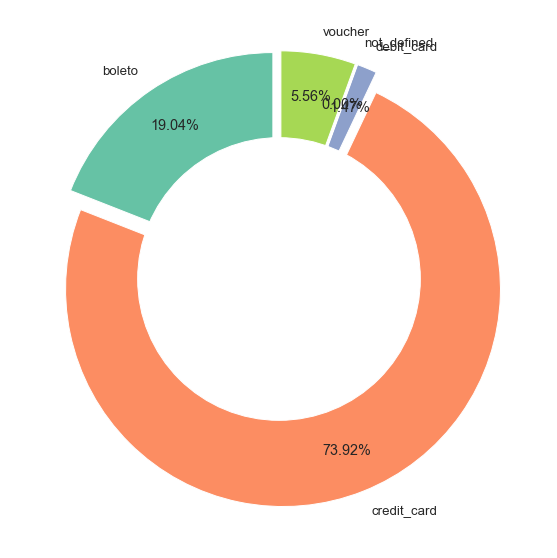

In [73]:
# order_payment values
payments = order_payment.groupby(['payment_type'])['payment_value'].agg(['count','sum']).reset_index()
#f, axes = plt.subplots(1,1,figsize=(10, 10), sharex=False, sharey = False)
''''
plt.subplot(1, 2, 1)
plt.pie(payments['count'],labels = payments['payment_type'],autopct = '%.2f %%')
plt.title('Payment Type in count')

plt.subplot(1,2,2)
plt.pie(payments['sum'],labels = payments['payment_type'],autopct = '%.2f %%')
plt.title('Payment Type in Summary')

plt.show()
'''
sns.set(font_scale = 1.2)
plt.figure(figsize=(10,10))

plt.pie(
    x=payments['count'], labels=payments['payment_type'],
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.2f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.show()

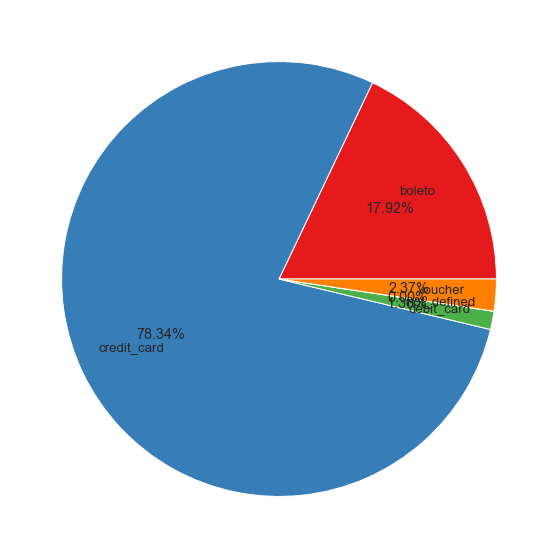

In [78]:
# Payment total value by payment method
sns.set(font_scale = 1.2)
plt.figure(figsize=(10, 10))

patches, texts, autotexts = plt.pie(
    x=payments['sum'], labels=payments['payment_type'], autopct='%1.2f%%',
    colors=sns.color_palette('Set1'),    labeldistance=0.75,
    # Distance of percent labels from the center
    pctdistance=0.6
)

# Customize text labels
for text in texts:
    text.set_horizontalalignment('center')

# Customize percent labels
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('normal')

plt.show()

In [49]:
# which city customer comes the most
customer_city = customers_loc.groupby(['customer_city'])['customer_id'].agg(['count']).reset_index().sort_values(by = 'count', ascending = True)
customer_city.head()
# Bar chart to show cities count
#sns.factorplot(x="count", y="customer_city", data = customer_city, kind="bar", size=8, aspect=1.9,row_order = 'count')
#plt.title('# of Record by Country')

,customer_city,count
3950,valao do barro,1
3998,vermelho,1
3655,serra dos dourados,1
846,carnaiba do sertao,1
3538,sao mateus de minas,1


In [33]:
customer_city.head(30)

,customer_city,count
2059,lagoao,1
2779,pedro gomes,1
814,caraibas,1
1930,japoata,1
2783,pedro velho,1
2784,peixe,1
810,caracol,1
1346,flora rica,1
1348,florania,1
807,capivari do sul,1


## Time Series Analysis